### Experiments with training different dataset 

Goal is to see if training on high freq leads to better performance on low freq dataset than training on low freq dataset for high freq data  

8/19

Imports

In [83]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse
import torch.nn.functional as F

Set save to True if you want to save plots

In [84]:
save = False

Only for python script: uncomment if running on cluster

In [85]:
# These are both placeholders
num_epochs = 1000
model_name = 'f0'

In [86]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [88]:
# For reproducibility
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

**Simplified function generation**

In [89]:
def generate_freq_dataset(num_samples, num_points, min_freq, max_freq):
    x = torch.linspace(0, 2 * np.pi, num_points, requires_grad=True)
    functions = []
    derivatives = []
    
    for _ in range(num_samples):
        # Fix maximum of 10 frequency components 
        num_freqs = torch.randint(1, 10, (1,)).item()
        amplitudes = torch.rand(num_freqs * 2)  # Double the number of amplitudes
        frequencies = torch.randint(min_freq, max_freq + 1, (num_freqs,)).float()
        phases = torch.rand(num_freqs * 2) * 2 * np.pi  # Double the number of phases
        
        y = sum(a * torch.sin(f * x + p) for a, f, p in zip(amplitudes[:num_freqs], frequencies, phases[:num_freqs])) + \
            sum(a * torch.cos(f * x + p) for a, f, p in zip(amplitudes[num_freqs:], frequencies, phases[num_freqs:]))
        
        dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        functions.append(y.detach().numpy())
        derivatives.append(dy_dx.detach().numpy())
    
    return np.array(functions), np.array(derivatives)

## Generate datasets

In [90]:
num_samples = 500
num_points = 1000
batch_size = 32

low_freq_functions, low_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 5)
general_freq_functions, general_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 15)
high_freq_functions, high_freq_derivatives = generate_freq_dataset(num_samples, num_points, 10, 15)

low_freq_dataset = TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives))
general_freq_dataset = TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives))
high_freq_dataset = TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives))

low_freq_dataloader = DataLoader(TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives)), batch_size=batch_size, shuffle=True)
high_freq_dataloader = DataLoader(TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives)), batch_size=batch_size, shuffle=True)
general_freq_dataloader = DataLoader(TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives)), batch_size=batch_size, shuffle=True)

In [91]:
total_size = len(low_freq_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)

# low freq
train_dataset_l, test_dataset_l = random_split(low_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

# general freq
train_dataset_g, test_dataset_g = random_split(general_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

# high freq
train_dataset_h, test_dataset_h = random_split(high_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)


## Plot random function from one of the datasets

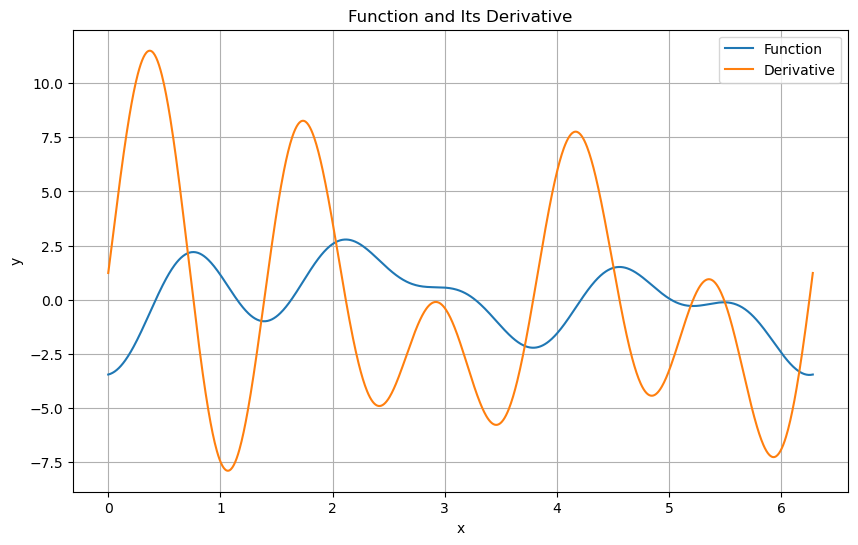

In [92]:
a = np.random.randint(32)

fun, deriv = next(iter(low_freq_dataloader))

first_function = fun[a]
first_derivative = deriv[a]

# Generate x values corresponding to the function inputs
x_values = np.linspace(0, 2 * np.pi, 1000)

# Plotting the function and its derivative
plt.figure(figsize=(10, 6))
plt.plot(x_values, first_function, label='Function')
plt.plot(x_values, first_derivative, label='Derivative')
plt.title('Function and Its Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
# Save datasets
# torch.save(general_freq_dataset, 'datasets/general_freq_dataset.pt')
# torch.save(low_freq_dataset, 'datasets/low_freq_dataset.pt')
# torch.save(high_freq_dataset, 'datasets/high_freq_dataset.pt')

Stopped here

## Model architecture

This CNN uses 3 layers, each with kernel size 3

In [94]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [95]:
f0 = SimpleCNN()
criterion = nn.MSELoss()

## Miscellaneous plotting functions

In [96]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [97]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

In [98]:
def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

## Function to train model

In [99]:
train_losses, test_losses = [], []

def model_training(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None, nmse=None):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = 1e-3

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define a new loss function that can use NMSE
    def criterion2(target, output, nmse=None):
        mse = torch.mean((target - output) ** 2)
        if nmse:
            mse = mse / torch.mean(target ** 2)
        
        return mse

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        if epoch % split_freq == 0:
            l, g, h = print_and_store_metrics(model)
            low_freq_nmses.append(l)
            general_freq_nmses.append(g)
            high_freq_nmses.append(h)
            epoch_list.append(epoch)

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion2(outputs, batch_derivatives, nmse=True)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion2(test_outputs, b_test_derivatives, nmse=True)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')

    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

## Metric functions

In [100]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

In [101]:
def print_and_store_metrics(f0):
    return compute_mse(train_dataloader_l, f0)[1], compute_mse(train_dataloader_g, f0)[1], compute_mse(train_dataloader_h, f0)[1]

In [102]:
def print_metrics(model):
    print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, model)[1]}")
    print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, model)[1]}")
    print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, model)[1]}")



## Create models

In [103]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, n_layers=3, kernel_size=3, hidden_size=64):
        super(SimpleCNN, self).__init__()
        # Parameters
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size

        # Model
        self.convs = nn.ModuleList()
        if n_layers == 1:
            self.convs.append(nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size//2))
        elif n_layers >= 2:
            self.convs.append(nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            for _ in range(n_layers - 2):
                self.convs.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            self.convs.append(nn.Conv1d(hidden_size, 1, kernel_size=kernel_size, padding=kernel_size//2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            if i < len(self.convs) - 1:
                x = self.relu(conv(x))
            else:
                x = conv(x)
        return x

In [104]:
set_seed(seed)
L3ModelK3 = SimpleCNN(n_layers=3, kernel_size=3)

## Plot results

In [105]:
def plot_all_outputs(model, model_name):
    plot_output(model, dataset=test_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

## Color map plots

In [ ]:
def compute_fft_and_max_freq(dataloader, deriv=False, model=None, residue=False):
    fft_amplitudes = []
    max_frequencies = []
    T = 2 * torch.pi
    N = 1000

    # Calculate frequencies for the FFT
    frequencies = torch.fft.fftfreq(N, T / (2 * torch.pi * N))
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    # Iterate over each batch
    for functions, derivatives in dataloader:  # Note that derivatives are ignored in this loop
        
        if deriv and not model: # If deriv is true and model is none then use derivatives
            functions = derivatives
            
        if not deriv and model and not residue: # If deriv is false and model is entered then compute derivative
            functions = model(functions.unsqueeze(1)).squeeze()
            # output = model(functions)
            
            # output = output.squeeze()
            # functions = output # set this so that the FFTs can be computed in the next line
        
        elif residue and model:
            print("computing residue")
            outputs = model(functions.unsqueeze(1)).squeeze()
            residues = derivatives - outputs
            norm_residues = residues / derivatives
            functions = norm_residues

        # Compute FFT using PyTorch
        F = torch.fft.fft(functions)
        magnitudes = torch.abs(F) / N

        # Consider only positive frequencies
        positive_magnitudes = magnitudes[:, positive_freq_indices]

        fft_amplitudes.append(positive_magnitudes)
        
        # Maximum frequency based on the highest amplitude for each function in the batch
        max_indices = torch.argmax(positive_magnitudes, dim=1)
        batch_max_freqs = positive_freqs[max_indices]
        max_frequencies.extend(batch_max_freqs)

    return torch.vstack(fft_amplitudes), torch.tensor(max_frequencies), positive_freqs

def plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type, xmin=0, xmax=0):
    fft_amplitudes = fft_amplitudes.detach().numpy()
    max_frequencies = max_frequencies.detach().numpy()
    freqs = freqs.detach().numpy()
    
    # Sort functions by the maximum frequency
    sorted_indices = np.argsort(-max_frequencies)  # Sort in descending order
    sorted_fft = fft_amplitudes[sorted_indices]

    plt.figure(figsize=(10, 6))
    im = plt.imshow(sorted_fft, aspect='auto', extent=[freqs[0], freqs[-1], 0, len(sorted_fft)],\
        interpolation='nearest')
    plt.colorbar(im, label='Amplitude')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Function Index (sorted by max frequency)')
    plt.title(f'FFT Amplitude Heatmap for {fun_type}')
    plt.xlim([xmin, xmax])
    plt.show()


In [ ]:
# Default is u_g
# This function plots the heatmaps for all frequencies for the test datlaoaders
def plot_heatmaps(deriv=None, model=None, residue=False, label=None):
    fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(test_dataloader_l,\
        deriv=deriv, model=model, residue=residue)
    plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'Low freq {label}', xmin=0, xmax=6)

    fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(test_dataloader_g,\
        deriv=deriv, model=model, residue=residue)
    plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'General freq {label}', xmin=0, xmax=16)

    fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(test_dataloader_h,\
        deriv=deriv, model=model, residue=residue)
    plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'High freq {label}', xmin=10, xmax=16)


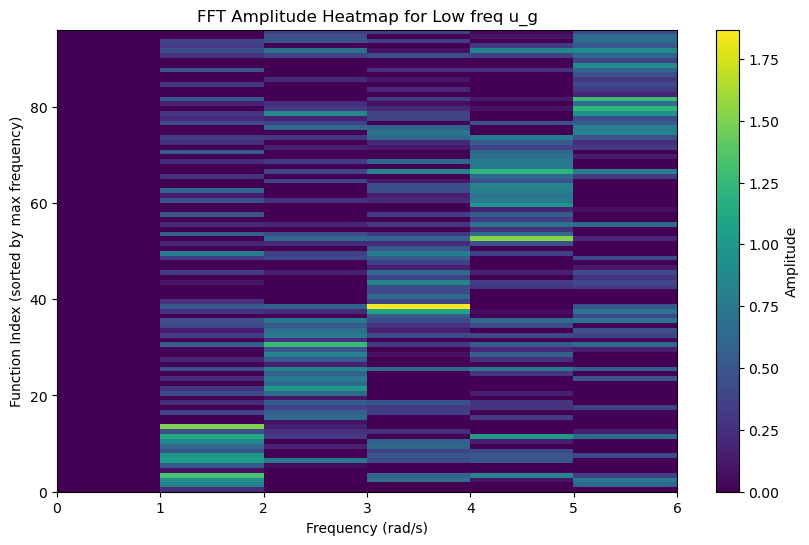

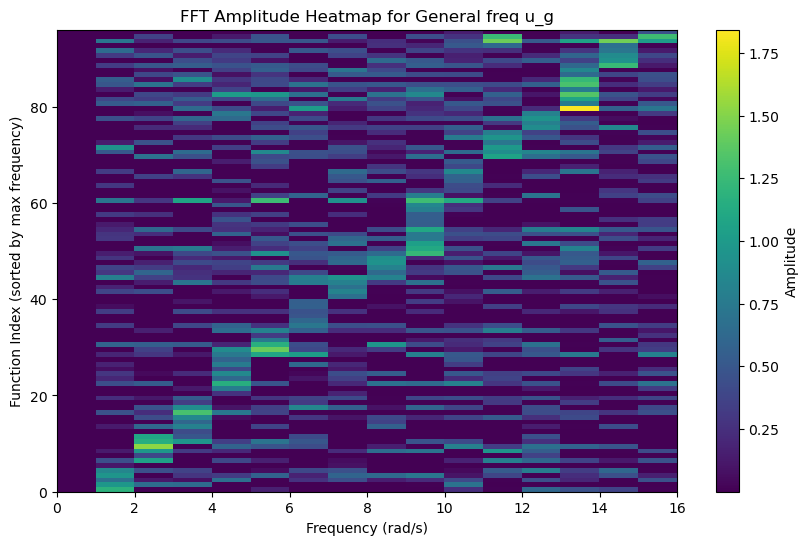

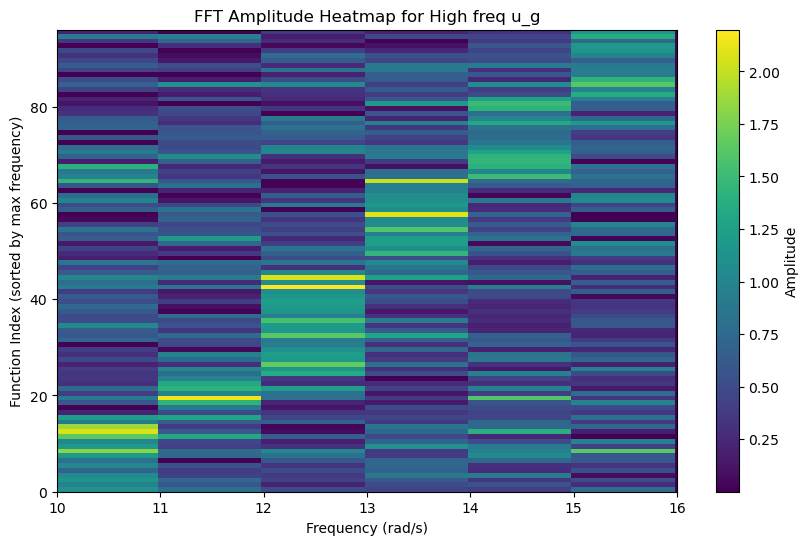

In [ ]:
plot_heatmaps(label='u_g')

## Experiments with training on different datasets

3 layers, kernel size 3

### Training on low frequency dataset only

Epoch [1/2000], Train Loss: 408.2800, Test Loss: 37.6448
Epoch [2/2000], Train Loss: 23.5638, Test Loss: 13.9673
Epoch [3/2000], Train Loss: 10.9776, Test Loss: 8.3092
Epoch [4/2000], Train Loss: 7.2933, Test Loss: 6.0929
Epoch [5/2000], Train Loss: 5.5839, Test Loss: 4.9651
Epoch [6/2000], Train Loss: 4.6322, Test Loss: 4.1830
Epoch [7/2000], Train Loss: 3.9143, Test Loss: 3.4724
Epoch [8/2000], Train Loss: 3.2237, Test Loss: 2.8423
Epoch [9/2000], Train Loss: 2.6791, Test Loss: 2.3788
Epoch [10/2000], Train Loss: 2.2499, Test Loss: 2.0611
Epoch [11/2000], Train Loss: 1.9690, Test Loss: 1.8543
Epoch [12/2000], Train Loss: 1.8010, Test Loss: 1.7107
Epoch [13/2000], Train Loss: 1.6830, Test Loss: 1.6062
Epoch [14/2000], Train Loss: 1.5791, Test Loss: 1.5289
Epoch [15/2000], Train Loss: 1.5078, Test Loss: 1.4701
Epoch [16/2000], Train Loss: 1.4537, Test Loss: 1.4235
Epoch [17/2000], Train Loss: 1.4124, Test Loss: 1.3852
Epoch [18/2000], Train Loss: 1.3774, Test Loss: 1.3523
Epoch [19/200

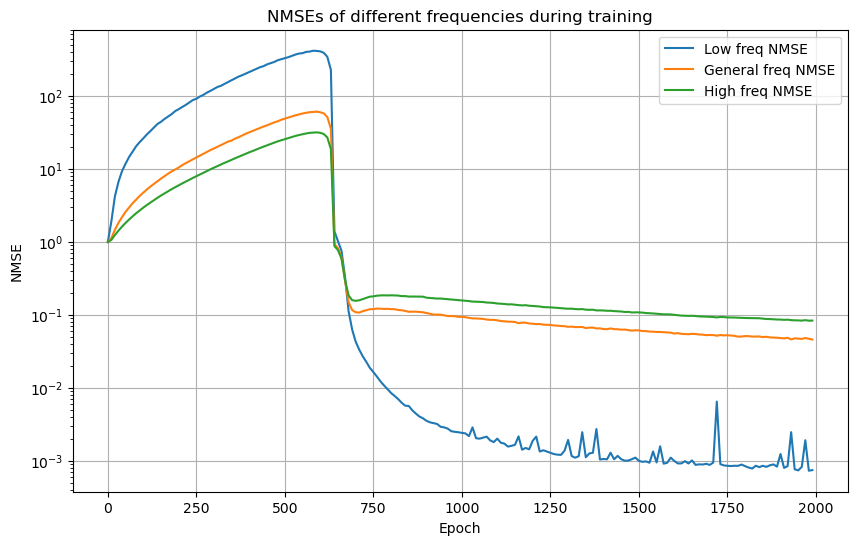

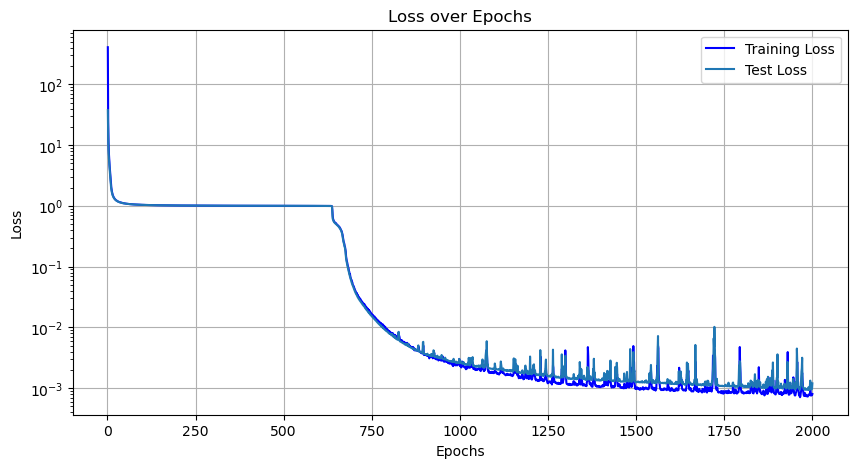

In [109]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)

train_losses, test_losses = model_training(L3ModelK3_low, train_dataloader_l, test_dataloader_l,\
    num_epochs=2000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first', nmse=True)
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [115]:
print_metrics(L3ModelK3_low)

NMSE over low freq test functions: 0.001168005052022636
NMSE over general freq test functions: 0.04704964905977249
NMSE over high freq test functions: 0.08218340575695038


In [117]:
(0.08218340575695038 - 0.001168005052022636) / 0.001168005052022636

69.36220058691806

### Training on high frequency data only

Epoch [1/2000], Train Loss: 15654.2786, Test Loss: 952.6394
Epoch [2/2000], Train Loss: 580.6807, Test Loss: 329.8079
Epoch [3/2000], Train Loss: 242.2315, Test Loss: 166.6383
Epoch [4/2000], Train Loss: 133.6691, Test Loss: 104.9319
Epoch [5/2000], Train Loss: 90.2658, Test Loss: 76.3688
Epoch [6/2000], Train Loss: 68.3965, Test Loss: 60.1213
Epoch [7/2000], Train Loss: 54.9422, Test Loss: 49.5206
Epoch [8/2000], Train Loss: 45.9238, Test Loss: 41.9823
Epoch [9/2000], Train Loss: 39.3473, Test Loss: 36.2796
Epoch [10/2000], Train Loss: 34.1228, Test Loss: 31.8585
Epoch [11/2000], Train Loss: 30.1707, Test Loss: 28.3076
Epoch [12/2000], Train Loss: 26.9539, Test Loss: 25.4068
Epoch [13/2000], Train Loss: 24.2633, Test Loss: 23.0130
Epoch [14/2000], Train Loss: 22.1210, Test Loss: 20.9938
Epoch [15/2000], Train Loss: 20.2008, Test Loss: 19.2816
Epoch [16/2000], Train Loss: 18.6222, Test Loss: 17.8069
Epoch [17/2000], Train Loss: 17.2209, Test Loss: 16.5334
Epoch [18/2000], Train Loss: 1

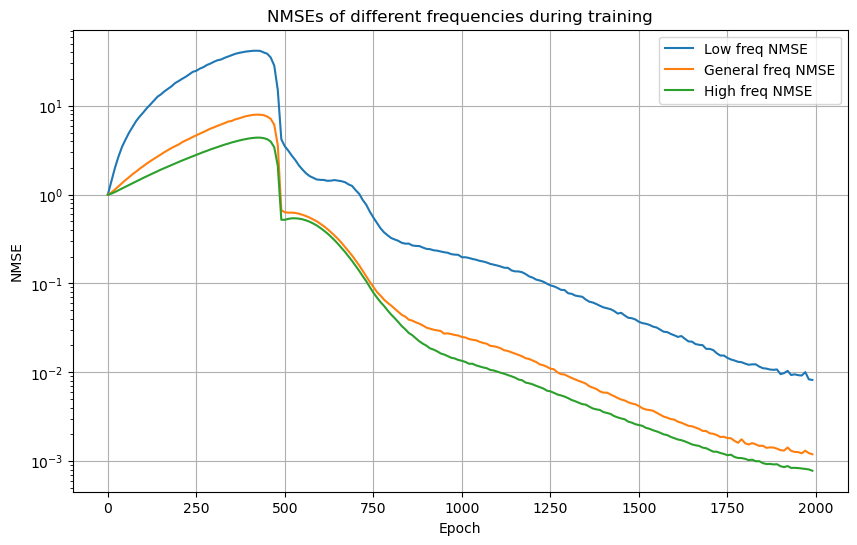

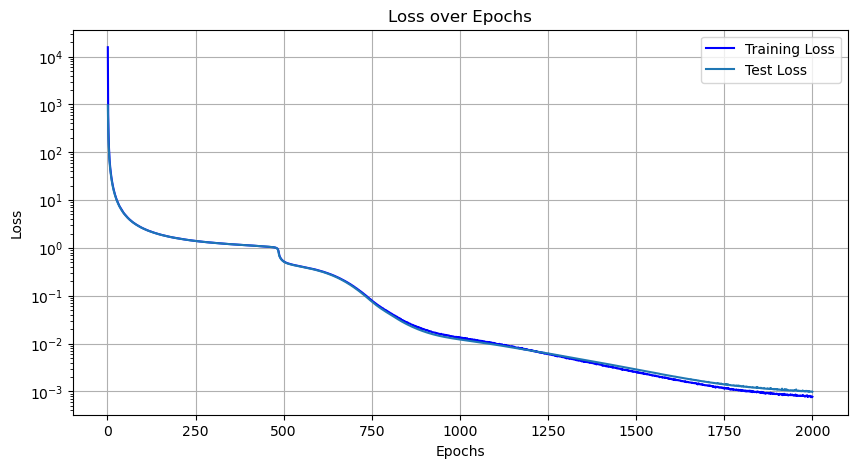

In [116]:
set_seed(seed)
L3ModelK3_high = SimpleCNN(n_layers=3, kernel_size=3)

train_losses, test_losses = model_training(L3ModelK3_high, train_dataloader_h, test_dataloader_h,\
    num_epochs=2000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first', nmse=True)
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [119]:
print_metrics(L3ModelK3_high)

NMSE over low freq test functions: 0.009635734371840954
NMSE over general freq test functions: 0.001374279847368598
NMSE over high freq test functions: 0.0009829183109104633


In [120]:
(0.009635734371840954 - 0.0009829183109104633)/ 0.0009829183109104633

8.803189405348965

**Training on the high frequency dataset leads to a smaller (better) performance difference on the low frequency data: it's about two orders of magnitude difference when training on the high frequency data vs three orders of magnitude difference when training on the low frequency data.**

### General frequency data

Epoch [1/2000], Train Loss: 6233.0030, Test Loss: 373.3850
Epoch [2/2000], Train Loss: 239.8062, Test Loss: 143.8028
Epoch [3/2000], Train Loss: 108.9981, Test Loss: 78.7628
Epoch [4/2000], Train Loss: 64.9927, Test Loss: 51.0294
Epoch [5/2000], Train Loss: 44.0089, Test Loss: 35.4484
Epoch [6/2000], Train Loss: 30.4817, Test Loss: 25.6997
Epoch [7/2000], Train Loss: 22.7527, Test Loss: 19.4892
Epoch [8/2000], Train Loss: 17.5101, Test Loss: 15.4462
Epoch [9/2000], Train Loss: 14.0522, Test Loss: 12.7226
Epoch [10/2000], Train Loss: 11.7950, Test Loss: 10.8082
Epoch [11/2000], Train Loss: 10.1720, Test Loss: 9.4161
Epoch [12/2000], Train Loss: 8.8801, Test Loss: 8.3658
Epoch [13/2000], Train Loss: 7.9795, Test Loss: 7.5380
Epoch [14/2000], Train Loss: 7.2309, Test Loss: 6.8353
Epoch [15/2000], Train Loss: 6.4992, Test Loss: 6.1818
Epoch [16/2000], Train Loss: 5.9533, Test Loss: 5.6647
Epoch [17/2000], Train Loss: 5.4820, Test Loss: 5.2505
Epoch [18/2000], Train Loss: 5.0794, Test Loss:

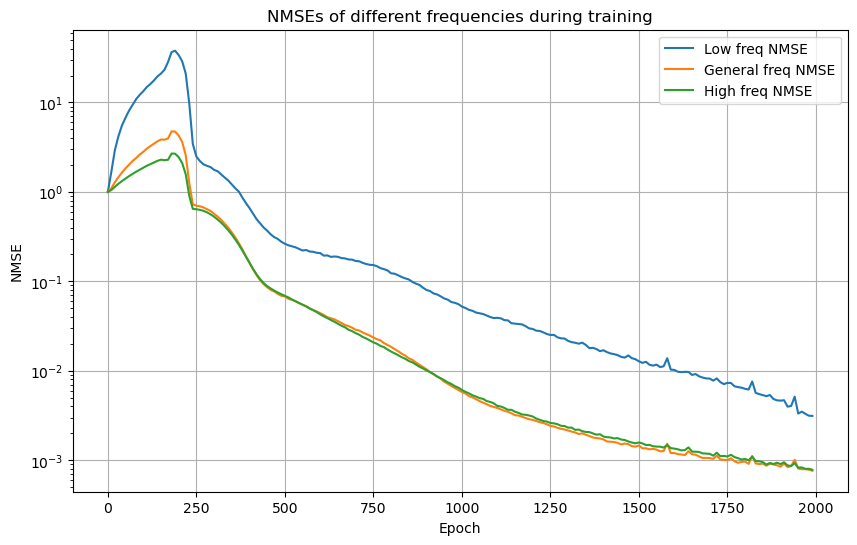

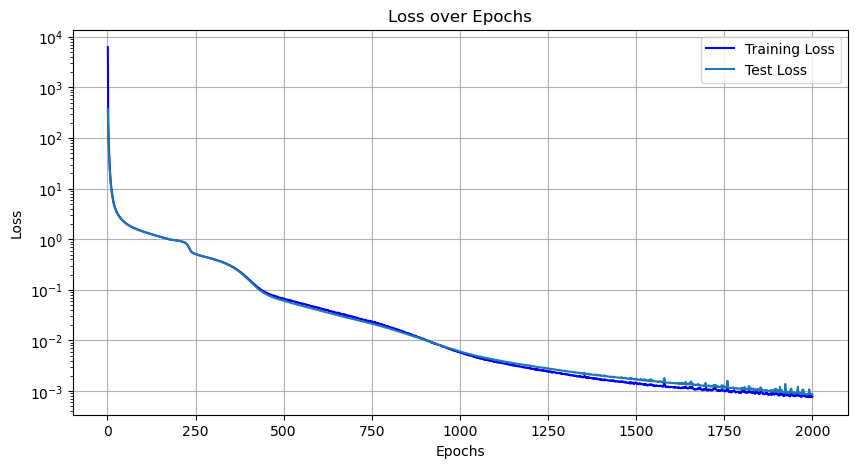

NMSE over low freq test functions: 0.0028191758319735527
NMSE over general freq test functions: 0.0008956343517638743
NMSE over high freq test functions: 0.0008776075555942953


In [121]:
set_seed(seed)
L3ModelK3_general = SimpleCNN(n_layers=3, kernel_size=3)

train_losses, test_losses = model_training(L3ModelK3_general, train_dataloader_g, test_dataloader_g,\
    num_epochs=2000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first', nmse=True)
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

print_metrics(L3ModelK3_general)

In [126]:
### Difference

(0.0028191758319735527 - 0.0008776075555942953) / 0.0008776075555942953

2.2123422525282077

### See model weights

In [ ]:
L3ModelK3_general

SimpleCNN(
  (convs): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (relu): ReLU()
  (tanh): Tanh()
)

In [ ]:
L3ModelK3_general.convs[0].weight

Parameter containing:
tensor([[[ 0.5872,  0.6052, -0.4130]],

        [[ 0.7475, -0.0532, -0.0728]],

        [[-0.5396,  0.4294,  0.6414]],

        [[-0.6480,  0.5928,  0.3060]],

        [[ 0.5506,  0.1938,  0.2579]],

        [[-0.0745,  0.6608,  0.0766]],

        [[-0.3429,  0.0562, -0.3712]],

        [[-0.2384, -0.2775,  0.5218]],

        [[-0.5445, -0.4239, -0.2043]],

        [[-0.3490, -0.0196, -0.6505]],

        [[ 0.7355, -0.5287,  0.5555]],

        [[ 0.3463, -0.3705,  0.4690]],

        [[-0.3901,  1.0459, -0.3648]],

        [[-0.2890,  0.0520, -0.2064]],

        [[ 0.2122,  0.6884,  0.2708]],

        [[-0.2403,  0.5218,  0.2158]],

        [[ 0.4169, -0.4557, -0.7121]],

        [[-0.2823, -0.3516,  0.6390]],

        [[ 0.2134,  0.3179,  0.1114]],

        [[ 0.1377,  0.4861, -0.6234]],

        [[-0.0162, -0.6077,  0.1027]],

        [[-0.3144,  0.0772, -0.1698]],

        [[ 0.5190, -0.5102, -0.4890]],

        [[-0.4983,  0.6912,  0.3260]],

        [[ 0.6384,

### Questions:
- Does training on high freq data lead to better performance on low freq data, or vice-versa? I.e., is the performance delta larger or smaller? 
    - Yes: training on high freq data leads to a smaller performance gap on the low freq data than vice-versa.
    - However, training on the general freq dataset leads to the best performance overall, **but there is a an opposite bias for some reason: high freq data has lower NMSE than low freq data, which is counterintuitive**
    - And, the general freq NMSE is almost identical to the high freq NMSE
- Need to plot the heatmap over epochs
- Is this happening because the **MSE** is larger for high freq data and therefore learning that better?
- Does changing the model architecture (layers or kernel size) change this bias?
- Can "fine-tuning" a model that was trained on high freq data with low freq data lead to better performance than just training on general freq?